In [20]:
%pip install --upgrade numpy mediapipe

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached mediapipe-0.10.18-cp312-cp312-win_amd64.whl.metadata (9.9 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.35-cp312-cp312-win_amd64.whl.metadata (1.0 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.1-py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached sentencepiece-0.2.0-cp312-cp312-win_amd64.whl.metadata (8.3 kB)
  Using cached cffi-1.17.1-cp312-cp312-win_amd64.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.5.0-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached pycparser-2.22-py3-none-any.whl

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\nehat\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\numpy\\_core\\_dtype.py'
Check the permissions.


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\nehat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


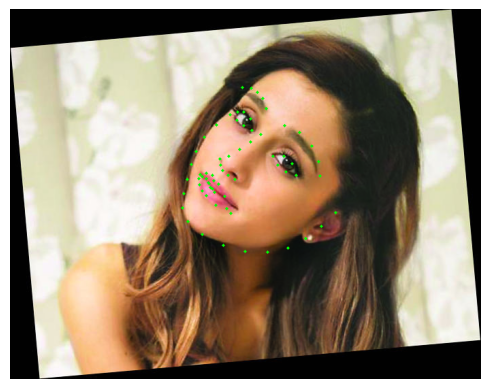

In [38]:
import dlib
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")  # Ensure this file is in the same directory or provide full path

# Read the image
image = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/ariana.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)

# Draw facial landmarks
for face in faces:
    landmarks = predictor(gray, face)
    for n in range(0, 68):  # Dlib provides 68 landmarks
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Sun glass with rotation

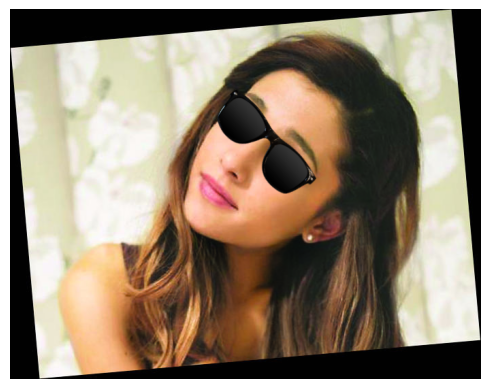

In [39]:
import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

# Read the image
image = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/ariana.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)

# Load the sunglasses image with alpha channel
sunglasses = cv2.imread("D:/CGGT/Computer Vision/FinalProject/filters/sunglasses.png", cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Sunglasses image not found. Check the path.")
    exit()

for face in faces:
    landmarks = predictor(gray, face)

    # Extract eye landmarks
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])

    # Calculate eye centers
    left_eye_center = left_eye_points.mean(axis=0).astype("int")
    right_eye_center = right_eye_points.mean(axis=0).astype("int")

    # Calculate angle between the eye centers
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = -math.degrees(math.atan2(dy, dx))

    # Calculate the scaling factor based on the distance between the eyes
    eye_width = np.linalg.norm(right_eye_center - left_eye_center)
    scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

    # Resize the sunglasses image
    new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
    new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
    resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

    # Prepare for rotation without cropping
    # Calculate the center of the sunglasses image
    center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate the sine and cosine of the rotation angle
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    # Compute the new bounding dimensions of the image
    bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
    bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

    # Adjust the rotation matrix to consider the translation
    M[0, 2] += bound_w / 2 - center[0]
    M[1, 2] += bound_h / 2 - center[1]

    # Perform the actual rotation and prevent cropping
    rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

    # Calculate position to place sunglasses
    x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
    y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

    # Adjust position for better fit (optional)
    y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

    # Ensure coordinates are within the image
    x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
    y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

    # Calculate regions
    sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

    # Ensure the sunglasses region is not empty
    if sunglasses_region.size == 0:
        continue  # Skip if the region is empty

    # Split channels and compute the mask
    if sunglasses_region.shape[2] == 4:
        # If the image has an alpha channel
        alpha_s = sunglasses_region[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s
        # Extract the RGB channels
        sunglasses_rgb = sunglasses_region[:, :, :3]
    else:
        # If the image does not have an alpha channel
        alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
        alpha_l = 1.0 - alpha_s
        sunglasses_rgb = sunglasses_region

    # Extract the region of interest from the image
    roi = image[y1:y2, x1:x2]

    # Blend the sunglasses with the ROI
    for c in range(0, 3):
        roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

    # Place the blended region back into the image
    image[y1:y2, x1:x2] = roi

# Display the result
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


# Sunglass without rotation

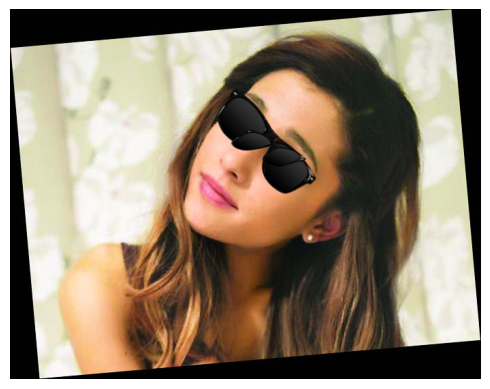

In [40]:
# SUNGLASSES

import math
# Adjust calculations to fit sunglasses better
left_eye_outer = landmarks.part(36)  # Point 36 is the left eye outer corner
right_eye_outer = landmarks.part(45)  # Point 45 is the right eye outer corner

# Calculate the midpoint and adjust downward to cover the eyes properly
sunglasses_center_x = int((left_eye_outer.x + right_eye_outer.x) / 2)
sunglasses_center_y = int((left_eye_outer.y + right_eye_outer.y) / 2) + 10  # Adjust 10 pixels down

# Adjust the size of the sunglasses
sunglasses_width = int(abs(right_eye_outer.x - left_eye_outer.x) * 1.5)  # Slightly reduced width
sunglasses_height = int(sunglasses_width * 0.5)  # Adjust height proportionally

# Get eye landmarks for rotation calculation
left_eye_outer = landmarks.part(36)
right_eye_outer = landmarks.part(45)

# Calculate angle of rotation
dy = right_eye_outer.y - left_eye_outer.y
dx = right_eye_outer.x - left_eye_outer.x
angle = -math.degrees(math.atan2(dy, dx))  # Angle in degrees

# Load, resize, and blend sunglasses as before
sunglasses = cv2.imread("D:/CGGT/Computer Vision/FinalProject/filters/sunglasses.png", cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Sunglasses image not found. Check the path.")
else:
    # Resize the sunglasses
    new_sunglasses = cv2.resize(sunglasses, (sunglasses_width, sunglasses_height), interpolation=cv2.INTER_AREA)

    # Rotate the sunglasses image
    rows, cols = new_sunglasses.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    # Calculate bounding box of rotated image
    rotated_rect = cv2.boundingRect(cv2.transform(np.array([[[0, 0]], [[cols, 0]], [[cols, rows]], [[0, rows]]], dtype=np.float32), M))
    rotated_width, rotated_height = rotated_rect[2], rotated_rect[3]

    # Adjust rotation matrix to center the rotated image
    M[0, 2] += rotated_width / 2 - cols / 2
    M[1, 2] += rotated_height / 2 - rows / 2

    # Warp the image with transparent border
    rotated_sunglasses = cv2.warpAffine(new_sunglasses, M, (rotated_width, rotated_height), borderValue=(0, 0, 0, 0))

    # Extract channels and create a mask
    b, g, r, alpha = cv2.split(rotated_sunglasses)
    sunglasses_rgb = cv2.merge((b, g, r))
    mask = alpha / 255.0

    # Calculate top-left corner for placing sunglasses
    x1 = int(sunglasses_center_x - sunglasses_width / 2)
    y1 = int(sunglasses_center_y - sunglasses_height / 2)

    # Ensure the coordinates are within bounds
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image.shape[1], x1 + sunglasses_width)
    y2 = min(image.shape[0], y1 + sunglasses_height)

    # Adjust dimensions if partially outside image bounds
    roi_width, roi_height = x2 - x1, y2 - y1
    resized_sunglasses_rgb = cv2.resize(sunglasses_rgb, (roi_width, roi_height), interpolation=cv2.INTER_AREA)
    resized_mask = cv2.resize(mask, (roi_width, roi_height), interpolation=cv2.INTER_AREA)

    # Extract ROI from the original image
    roi = image[y1:y2, x1:x2]

    # Apply the mask to blend sunglasses into the ROI
    for c in range(3):
        roi[:, :, c] = (1.0 - resized_mask) * roi[:, :, c] + resized_mask * resized_sunglasses_rgb[:, :, c]

    # Place the final result back into the original image
    image[y1:y2, x1:x2] = roi

# Display the result
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


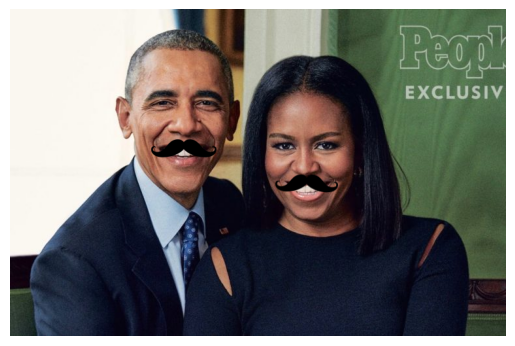

In [42]:
# FOR THE MUSTACHE

import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

# Read the image
image = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/obamas.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)

# Load the sunglasses image with alpha channel
sunglasses = cv2.imread("D:/CGGT/Computer Vision/FinalProject/filters/moustache.png", cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Moustache image not found. Check the path.")
    exit()

for face in faces:
    landmarks = predictor(gray, face)

     # Extract eye landmarks
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 51)])
    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(52, 55)])

    # Calculate eye centers
    left_eye_center = left_eye_points.mean(axis=0).astype("int")
    right_eye_center = right_eye_points.mean(axis=0).astype("int")

    # Calculate angle between the eye centers
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = -math.degrees(math.atan2(dy, dx))

    # Calculate the scaling factor based on the distance between the eyes
    eye_width = np.linalg.norm(right_eye_center - left_eye_center)
    scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

    # Resize the sunglasses image
    new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
    new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
    resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

    # Prepare for rotation without cropping
    # Calculate the center of the sunglasses image
    center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate the sine and cosine of the rotation angle
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    # Compute the new bounding dimensions of the image
    bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
    bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

    # Adjust the rotation matrix to consider the translation
    M[0, 2] += bound_w / 2 - center[0]
    M[1, 2] += bound_h / 2 - center[1]

    # Perform the actual rotation and prevent cropping
    rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

    # Calculate position to place sunglasses
    x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
    y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

    # Adjust position for better fit (optional)
    y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

    # Ensure coordinates are within the image
    x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
    y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

    # Calculate regions
    sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

    # Ensure the sunglasses region is not empty
    if sunglasses_region.size == 0:
        continue  # Skip if the region is empty

    # Split channels and compute the mask
    if sunglasses_region.shape[2] == 4:
        # If the image has an alpha channel
        alpha_s = sunglasses_region[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s
        # Extract the RGB channels
        sunglasses_rgb = sunglasses_region[:, :, :3]
    else:
        # If the image does not have an alpha channel
        alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
        alpha_l = 1.0 - alpha_s
        sunglasses_rgb = sunglasses_region

    # Extract the region of interest from the image
    roi = image[y1:y2, x1:x2]

    # Blend the sunglasses with the ROI
    for c in range(0, 3):
        roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

    # Place the blended region back into the image
    image[y1:y2, x1:x2] = roi

# Display the result
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


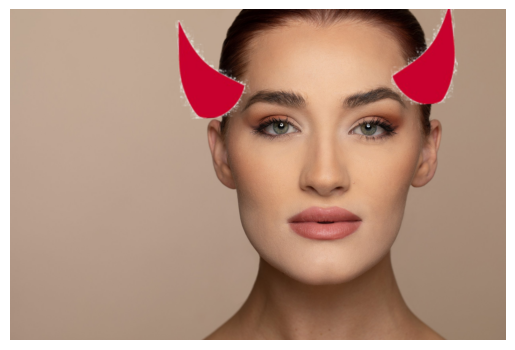

In [ ]:
# FOR THE HORNS

import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

# Read the image
image = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/obamas.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)

# Load the sunglasses image with alpha channel
horns = cv2.imread('/content/drive/MyDrive/Final_Project/facial_keypoint_detection/images/horns.png', cv2.IMREAD_UNCHANGED)
if horns is None:
    print("Moustache image not found. Check the path.")
    exit()

for face in faces:
    landmarks = predictor(gray, face)

    # Extract points above the eyes (forehead level)
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 19)])
    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(24, 26)])

    # Calculate eye centers
    left_eye_center = left_eye_points.mean(axis=0).astype("int")
    right_eye_center = right_eye_points.mean(axis=0).astype("int")

    # Calculate angle between the eye centers
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = -math.degrees(math.atan2(dy, dx))

    # Calculate the scaling factor based on the distance between the eyes
    eye_width = np.linalg.norm(right_eye_center - left_eye_center)
    scaling_factor = eye_width / horns.shape[1] * 2.0  # Adjust scaling factor as needed

    # Resize the horn image
    new_horns_width = int(horns.shape[1] * scaling_factor)
    new_horns_height = int(horns.shape[0] * scaling_factor)
    resized_horns = cv2.resize(horns, (new_horns_width, new_horns_height), interpolation=cv2.INTER_AREA)

    # Prepare for rotation without cropping
    center = (new_horns_width // 2, new_horns_height // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    # New bounding dimensions after rotation
    bound_w = int(new_horns_width * abs_cos + new_horns_height * abs_sin)
    bound_h = int(new_horns_width * abs_sin + new_horns_height * abs_cos)
    M[0, 2] += bound_w / 2 - center[0]
    M[1, 2] += bound_h / 2 - center[1]
    rotated_horns = cv2.warpAffine(resized_horns, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

    # Position horns on the forehead
    forehead_y_offset = -int(bound_h * 0.3)  # Adjust for forehead placement
    x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
    y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2) + forehead_y_offset

    # Define overlay region in main image with boundary checks
    x1 = max(x, 0)
    x2 = min(x + bound_w, image.shape[1])
    y1 = max(y, 0)
    y2 = min(y + bound_h, image.shape[0])

    # Corresponding region in horns image
    overlay_x1 = x1 - x
    overlay_x2 = x2 - x
    overlay_y1 = y1 - y
    overlay_y2 = y2 - y

    # Crop the rotated horns to fit within the image boundaries
    overlay_x2 = min(overlay_x2, rotated_horns.shape[1])
    overlay_y2 = min(overlay_y2, rotated_horns.shape[0])

    # Extract the regions from both images
    overlay_region = rotated_horns[overlay_y1:overlay_y2, overlay_x1:overlay_x2]
    roi = image[y1:y2, x1:x2]

    # Ensure the overlay region is not empty
    if overlay_region.size == 0 or roi.size == 0:
        continue  # Skip if the region is empty

    # Blend the horns with the main image using the alpha channel
    if overlay_region.shape[2] == 4:
        alpha_s = overlay_region[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s
        overlay_rgb = overlay_region[:, :, :3]
    else:
        alpha_s = np.ones((overlay_region.shape[0], overlay_region.shape[1]))
        alpha_l = 1.0 - alpha_s
        overlay_rgb = overlay_region

    # Apply blending
    for c in range(0, 3):
        roi[:, :, c] = (alpha_s * overlay_rgb[:, :, c] + alpha_l * roi[:, :, c])

    # Place the blended region back into the main image
    image[y1:y2, x1:x2] = roi

# Display the result
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

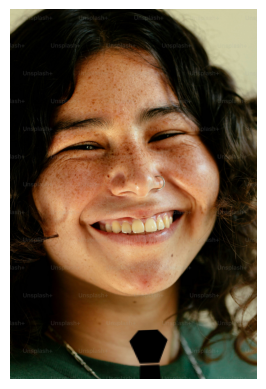

In [ ]:
# FOR THE NECKTIE

import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

# Read the image
image = cv2.imread('D:/CGGT/Computer Vision/FinalProject/Images/premium_photo-1664203067979-47448934fd97.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)

# Load the sunglasses image with alpha channel
sunglasses = cv2.imread('D:/CGGT/Computer Vision/FinalProject/filters/tie.png', cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Tie image not found. Check the path.")
    exit()

for face in faces:
    landmarks = predictor(gray, face)

     # Extract eye landmarks
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(7, 8)])
    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(8, 9)])

    # Calculate eye centers
    left_eye_center = left_eye_points.mean(axis=0).astype("int")
    right_eye_center = right_eye_points.mean(axis=0).astype("int")

    # Calculate angle between the eye centers
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = -math.degrees(math.atan2(dy, dx))

    # Calculate the scaling factor based on the distance between the eyes
    eye_width = np.linalg.norm(right_eye_center - left_eye_center)
    scaling_factor = eye_width / sunglasses.shape[1] * 10.0  # Adjust scaling factor for tie!!

    # Resize the sunglasses image
    new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
    new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
    resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

    # Prepare for rotation without cropping
    # Calculate the center of the sunglasses image
    center = (new_sunglasses_width // 2, 0)

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Calculate the sine and cosine of the rotation angle
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    # Compute the new bounding dimensions of the image
    bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
    bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

    # Adjust the rotation matrix to consider the translation
    M[0, 2] += bound_w / 2 - center[0]
    M[1, 2] += bound_h / 2 - center[1]

    # Perform the actual rotation and prevent cropping
    rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

    # Calculate position to place sunglasses
    x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
    y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

    # Adjust position for better fit (optional)
    y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

    # Ensure coordinates are within the image
    x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
    y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

    # Calculate regions
    sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

    # Ensure the sunglasses region is not empty
    if sunglasses_region.size == 0:
        continue  # Skip if the region is empty

    # Split channels and compute the mask
    if sunglasses_region.shape[2] == 4:
        # If the image has an alpha channel
        alpha_s = sunglasses_region[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s
        # Extract the RGB channels
        sunglasses_rgb = sunglasses_region[:, :, :3]
    else:
        # If the image does not have an alpha channel
        alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
        alpha_l = 1.0 - alpha_s
        sunglasses_rgb = sunglasses_region

    # Extract the region of interest from the image
    roi = image[y1:y2, x1:x2]

    # Blend the sunglasses with the ROI
    for c in range(0, 3):
        roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

    # Place the blended region back into the image
    image[y1:y2, x1:x2] = roi

# Display the result
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()



Avatar Filter

In [13]:
import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt

# Open the default camera
cam = cv2.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

# Load the sunglasses image with alpha channel
sunglasses = cv2.imread("D:/CGGT/Computer Vision/FinalProject/filters/moustache.png", cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Moustache image not found. Check the path.")
    exit()

while True:
    #ret, frame = cam.read()
    
    success, image = cam.read()
    #results = model(img, stream=True)
    
    # Read the image
    #image = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/obamas.jpg")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)

        # Extract eye landmarks
        left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 51)])
        right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(52, 55)])

        # Calculate eye centers
        left_eye_center = left_eye_points.mean(axis=0).astype("int")
        right_eye_center = right_eye_points.mean(axis=0).astype("int")

        # Calculate angle between the eye centers
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = -math.degrees(math.atan2(dy, dx))

        # Calculate the scaling factor based on the distance between the eyes
        eye_width = np.linalg.norm(right_eye_center - left_eye_center)
        scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

        # Resize the sunglasses image
        new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
        new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
        resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

        # Prepare for rotation without cropping
        # Calculate the center of the sunglasses image
        center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

        # Get rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Calculate the sine and cosine of the rotation angle
        abs_cos = abs(M[0, 0])
        abs_sin = abs(M[0, 1])

        # Compute the new bounding dimensions of the image
        bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
        bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

        # Adjust the rotation matrix to consider the translation
        M[0, 2] += bound_w / 2 - center[0]
        M[1, 2] += bound_h / 2 - center[1]

        # Perform the actual rotation and prevent cropping
        rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

        # Calculate position to place sunglasses
        x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
        y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

        # Adjust position for better fit (optional)
        y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

        # Ensure coordinates are within the image
        x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
        y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

        # Calculate regions
        sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

        # Ensure the sunglasses region is not empty
        if sunglasses_region.size == 0:
            continue  # Skip if the region is empty

        # Split channels and compute the mask
        if sunglasses_region.shape[2] == 4:
            # If the image has an alpha channel
            alpha_s = sunglasses_region[:, :, 3] / 255.0
            alpha_l = 1.0 - alpha_s
            # Extract the RGB channels
            sunglasses_rgb = sunglasses_region[:, :, :3]
        else:
            # If the image does not have an alpha channel
            alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
            alpha_l = 1.0 - alpha_s
            sunglasses_rgb = sunglasses_region

        # Extract the region of interest from the image
        roi = image[y1:y2, x1:x2]

        # Blend the sunglasses with the ROI
        for c in range(0, 3):
            roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

        # Place the blended region back into the image
        image[y1:y2, x1:x2] = roi

    # Display the result
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imshow('Webcam', image_rgb)

        # Write the frame to the output file
        #out.write(frame)

        # Display the captured frame
        #cv2.imshow('Camera', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# Release the capture and writer objects
cam.release()
#out.release()
cv2.destroyAllWindows()

In [15]:
import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt

# Open the default camera
cam = cv2.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

# Load the sunglasses image with alpha channel
sunglasses = cv2.imread("D:/CGGT/Computer Vision/FinalProject/filters/moustache.png", cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Moustache image not found. Check the path.")
    exit()

while True:
    #ret, frame = cam.read()
    
    success, image = cam.read()
    #results = model(img, stream=True)
    
    # Read the image
    #image = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/obamas.jpg")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)

        # Extract eye landmarks
        left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 51)])
        right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(52, 55)])

        # Calculate eye centers
        left_eye_center = left_eye_points.mean(axis=0).astype("int")
        right_eye_center = right_eye_points.mean(axis=0).astype("int")

        # Calculate angle between the eye centers
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = -math.degrees(math.atan2(dy, dx))

        # Calculate the scaling factor based on the distance between the eyes
        eye_width = np.linalg.norm(right_eye_center - left_eye_center)
        scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

        # Resize the sunglasses image
        new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
        new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
        resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

        # Prepare for rotation without cropping
        # Calculate the center of the sunglasses image
        center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

        # Get rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Calculate the sine and cosine of the rotation angle
        abs_cos = abs(M[0, 0])
        abs_sin = abs(M[0, 1])

        # Compute the new bounding dimensions of the image
        bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
        bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

        # Adjust the rotation matrix to consider the translation
        M[0, 2] += bound_w / 2 - center[0]
        M[1, 2] += bound_h / 2 - center[1]

        # Perform the actual rotation and prevent cropping
        rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

        # Calculate position to place sunglasses
        x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
        y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

        # Adjust position for better fit (optional)
        y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

        # Ensure coordinates are within the image
        x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
        y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

        # Calculate regions
        sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

        # Ensure the sunglasses region is not empty
        if sunglasses_region.size == 0:
            continue  # Skip if the region is empty

        # Split channels and compute the mask
        if sunglasses_region.shape[2] == 4:
            # If the image has an alpha channel
            alpha_s = sunglasses_region[:, :, 3] / 255.0
            alpha_l = 1.0 - alpha_s
            # Extract the RGB channels
            sunglasses_rgb = sunglasses_region[:, :, :3]
        else:
            # If the image does not have an alpha channel
            alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
            alpha_l = 1.0 - alpha_s
            sunglasses_rgb = sunglasses_region

        # Extract the region of interest from the image
        roi = image[y1:y2, x1:x2]

        # Blend the sunglasses with the ROI
        for c in range(0, 3):
            roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

        # Place the blended region back into the image
        image[y1:y2, x1:x2] = roi

    # Display the result
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imshow('Webcam', image)

        # Write the frame to the output file
        #out.write(frame)

        # Display the captured frame
        #cv2.imshow('Camera', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# Release the capture and writer objects
cam.release()
#out.release()
cv2.destroyAllWindows()

In [1]:
# Function to keep a number between 0 and the image size - 1 (inclusive)
def clamp(arr, min_val, max_val):
    return np.minimum(np.maximum(arr, min_val), max_val).astype(int)

Filters!!!

In [ ]:
def resizeImg(img, w, h):
    
    newImg = np.zeros((w, h))
    
    newImg[0:0, w:h] = img
    
    pass

In [3]:
import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt
import noise
from scipy import signal
import random 

# Open the default camera
cam = cv2.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

otherImg = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/Carina_Nebula-1.jpeg")


oldframe = None

filter_type = "ditherOLD"

oldframeLst = []

while True:
    #ret, frame = cam.read()
    
    success, image = cam.read()
    #results = model(img, stream=True)
    
    # Read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # stole these numbers from project 2! 
    
    # all the below filters (unless otherwise attributed) were made from referencing assignments for this class 
    # and previous knowledge of graphics 
    if filter_type == "gaussian":
        #kernel = np.array([[2,4,5,4,2], [4,9,12,9,4], [5,12,15,12,5], [4,9,12,9,4], [2,4,5,4,2]], dtype="float")
        #kernel_gauss = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype="float") / 16
        #kernel_gauss = np.array([[0.77484866790,1.5616633440,-0.36497642480,0.27514156450,-0.20531817470], [4,9,12,9,4], [5,12,15,12,5], [4,9,12,9,4], [2,4,5,4,2]], dtype="float")
        #kernel_gauss = np.array([[1/16, 1/8, 1/16], [1/8, 1/4, 1/8], [1/16, 1/8, 1/16]], dtype="float")
        #kernel /= kernel.sum()
        
        #kernel = np.array([[1/64.0, 1/48.0, 1/32.0, 1/48.0, 1/64.0], [1/32.0, 1/16.0, 1/8.0, 1/16.0, 1/32.0], [1/8.0, 1/4.0, 1/2.0, 1/4.0, 1/8.0], [1/32.0, 1/16.0, 1/8.0, 1/16.0, 1/32.0], [1/64.0, 1/48.0, 1/32.0, 1/48.0, 1/64.0]], dtype="float")
        #kernel = np.array([[1/16, 1/8, 1/16], [1/8, 1/4, 1/8], [1/16, 1/8, 1/16]], dtype="float")
        
        kernel = np.array([[0.0030, 0.0133, 0.0219, 0.0133, 0.0030],
                            [0.0133, 0.0596, 0.0983, 0.0596, 0.0133   ],
                            [0.0219, 0.0983,   0.1621,   0.0983 ,   0.0219   ],
                            [0.0133, 0.0596,    0.0983,   0.0596  ,  0.0133   ],
                            [0.0030, 0.0133, 0.0219,    0.0133,    0.0030   ]], dtype="float")

        # red channel
        gauss = signal.convolve2d(image[:, :, 0], kernel, mode='same', boundary='symm')
        gauss = np.clip(gauss, 0, 255).astype("uint8")
        image[:, :, 0] = gauss
        
        # blue channel
        gauss = signal.convolve2d(image[:, :, 1], kernel, mode='same', boundary='symm')
        gauss = np.clip(gauss, 0, 255).astype("uint8")
        image[:, :, 1] = gauss
        
        # green channel 
        gauss = signal.convolve2d(image[:, :, 2], kernel, mode='same', boundary='symm')
        gauss = np.clip(gauss, 0, 255).astype("uint8")
        image[:, :, 2] = gauss
        
        #gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype="int")
        #gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype="int")
        
        #image = signal.convolve2d(image, gx, mode='same', boundary='symm')
        #image = signal.convolve2d(image, gy, mode='same', boundary='symm')
            
    elif filter_type == "sobel":
    
        
        gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype="int")
        gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype="int")
        
        sobelx = signal.convolve2d(gray, gx, mode='same', boundary='symm')
        sobely = signal.convolve2d(gray, gy, mode='same', boundary='symm')
        sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
        
        sobel = np.clip(sobel, 0, 255).astype("uint8")
        
        img_blur = cv2.GaussianBlur(gray, (3,3), 0) # using built in to make life easier
        sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
        
        image = sobel
        
    elif filter_type == "sepia":
        sepia_img = image.copy()
        # had to borrow known values b/c my own looked too blue 
        sepia_vals = np.array(
                    [[0.272, 0.534, 0.131],
                    [0.349, 0.686, 0.168],
                    [0.393, 0.769, 0.189]]
                )
        
        sepia_img = sepia_img.dot(sepia_vals.T)
        sepia_img = np.clip(sepia_img, 0, 255).astype(np.uint8)

        image = sepia_img
    
    elif filter_type == "filmgrain":
        
        # h = image.shape[0]
        # w = image.shape[1]
                
        # for i in range(h):
        #     for j in range(w):
                
        #         randNum = random.randrange(0, 100)

        #         if randNum < 20:             
        #             image[i, j, 0] = image[i, j, 0] * 0.8
        #             image[i, j, 1] = image[i, j, 0] * 0.8
        #             image[i, j, 2] = image[i, j, 0] * 0.8
                
        #         elif randNum < 40: 
        #             image[i, j, 0] = image[i, j, 0] * 0.6
        #             image[i, j, 1] = image[i, j, 0] * 0.6
        #             image[i, j, 2] = image[i, j, 0] * 0.6
                    
        #         elif randNum < 60: 
        #             image[i, j, 0] = image[i, j, 0] * 0.5
        #             image[i, j, 1] = image[i, j, 0] * 0.5
        #             image[i, j, 2] = image[i, j, 0] * 0.5
                
        #         elif randNum < 80: 
        #             image[i, j, 0] = image[i, j, 0] * 0.4
        #             image[i, j, 1] = image[i, j, 0] * 0.4
        #             image[i, j, 2] = image[i, j, 0] * 0.4
                    
        #         else: 
        #             image[i, j, 0] = image[i, j, 0] * 0.2
        #             image[i, j, 1] = image[i, j, 0] * 0.2
        #             image[i, j, 2] = image[i, j, 0] * 0.2
        
        h, w, _ = image.shape  
        x, y = np.meshgrid(np.arange(w), np.arange(h))  
        rand_nums = np.random.randint(0, 100, size=(h, w)) 
        #print(rand_nums)
        # Apply film grain effect based on random numbers
        image[rand_nums < 20] = image[rand_nums < 20] * 0.8  # Darken some pixels by 20%
        image[np.logical_and(rand_nums >= 20, rand_nums < 40)] = image[np.logical_and(rand_nums >= 20, rand_nums < 40)] * 0.6  # Darken some pixels by 40%
        image[np.logical_and(rand_nums >= 40, rand_nums < 60)] = image[np.logical_and(rand_nums >= 40, rand_nums < 60)] * 0.5  # Darken some pixels by 50%
        image[np.logical_and(rand_nums >= 60, rand_nums < 80)] = image[np.logical_and(rand_nums >= 60, rand_nums < 80)] * 1.2  # Lighten some pixels by 20%
        image[np.logical_and(rand_nums >= 80, rand_nums < 100)] = image[np.logical_and(rand_nums >= 80, rand_nums < 100)] * 1.4
                    
    elif filter_type == "pixelate":
        kernel = np.ones((3, 3)) / 9
        pixel_size = 5  # Adjust for the desired pixelation level

        # pixelate
        downsample = image[::pixel_size, ::pixel_size]

        downsample[:, :, 0] = signal.convolve2d(downsample[:, :, 0], kernel, mode='same', boundary='symm')
        downsample[:, :, 1] = signal.convolve2d(downsample[:, :, 1], kernel, mode='same', boundary='symm')
        downsample[:, :, 2] = signal.convolve2d(downsample[:, :, 2], kernel, mode='same', boundary='symm')

        # back  to norm 
        pixelated_image = np.repeat(np.repeat(downsample, pixel_size, axis=0), pixel_size, axis=1)

        image = np.clip(pixelated_image, 0, 255).astype(np.uint8)
        
        pass

    elif filter_type == "negative":
        h, w, _ = image.shape  
        x, y = np.meshgrid(np.arange(w), np.arange(h))
        
        image[:, :, 0] = np.clip(255.0 - image[:, :, 0], 0, 255) 
        image[:, :, 1] = np.clip(255.0 - image[:, :, 1], 0, 255)
        image[:, :, 2] = np.clip(255.0 - image[:, :, 2], 0, 255) 
        
    # debug with white frame 
    elif filter_type == "ditherOLD":
        # reference: https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering 
        for y in range(1, gray.shape[1]-1):
            for x in range(1, gray.shape[0]-1):
                oldpixel = gray[x, y]
                if oldpixel > 128:
                    newpixel = 255
                else:
                    newpixel = 0
                gray[x, y] = newpixel
                quant_error = oldpixel - newpixel
                
                gray[x + 1, y] += quant_error * (7 / 16)
                gray[x - 1, y + 1] += quant_error * (3 / 16)
                gray[x, y + 1] += quant_error * (5 / 16)
                gray[x + 1, y + 1] += quant_error * (1 / 16)
        
        image = gray 
        
        pass
    
    # change to blend black to blend with original vid
    elif filter_type == "dither":
        gray = gray.astype(np.float32)  # Convert to float for precise error handling
        height, width = gray.shape

        for y in range(height - 1):  # Iterate over rows
            # Process one row at a time
            old_row = gray[y, :]  # Current row
            new_row = np.where(old_row > 96, 255, 0)  # Threshold
            gray[y, :] = new_row  # Update row in image
            quant_error = old_row - new_row  # Calculate quantization error

            # Distribute errors to neighboring pixels in the next row
            if y + 1 < height:
                gray[y + 1, :-1] += quant_error[1:] * (3 / 16)  # Bottom-left
                gray[y + 1, :] += quant_error * (5 / 16)  # Directly below
                gray[y + 1, 1:] += quant_error[:-1] * (1 / 16)  # Bottom-right

            # Distribute errors to the right pixel in the current row
            gray[y, 1:] += quant_error[:-1] * (7 / 16)  # Right neighbor

        image = np.clip(gray, 0, 255).astype(np.uint8)
    
    elif filter_type == "kuwahara":
        
        # inspiration: https://github.com/adussault/python-kuwahara/blob/master/Kuwahara.py#L96
        # also inspiration: https://en.wikipedia.org/wiki/Kuwahara_filter# 
        
        imageFloat = gray.astype(np.float64)

        winsize = 9

        #Build subwindows
        tmpAvgKerRow = np.hstack((np.ones((1,int((winsize-1)/2+1))),np.zeros((1,int((winsize-1)/2)))))
        tmpPadder = np.zeros((1,winsize))
        tmpavgker = np.tile(tmpAvgKerRow, (int((winsize-1)/2+1),1))
        tmpavgker = np.vstack((tmpavgker, np.tile(tmpPadder, (int((winsize-1)/2),1))))
        tmpavgker = tmpavgker/np.sum(tmpavgker)

        # tmpavgker is a 'north-west' subwindow (marked as 'a' above)
        # we build a vector of convolution kernels for computing average and
        # variance
        avgker = np.empty((4,winsize,winsize)) # make an empty vector of arrays
        avgker[0] = tmpavgker			# North-west (a)
        avgker[1] = np.fliplr(tmpavgker)	# North-east (b)
        avgker[2] = np.flipud(tmpavgker)	# South-west (c)
        avgker[3] = np.fliplr(avgker[2])	# South-east (d)
        
        # Create a pixel-by-pixel square of the image
        squaredImg = imageFloat**2
        
        # preallocate these arrays to make it apparently %15 faster
        avgs = np.zeros([4, imageFloat.shape[0],imageFloat.shape[1]])
        stddevs = avgs.copy()

        # Calculation of averages and variances on subwindows
        for k in range(4):
            avgs[k] = signal.convolve2d(imageFloat, avgker[k],mode='same') 	    # mean on subwindow
            stddevs[k] = signal.convolve2d(squaredImg, avgker[k],mode='same')  # mean of squares on subwindow
            stddevs[k] = stddevs[k]-avgs[k]**2 			    # variance on subwindow
        
        # Choice of index with minimum variance
        indices = np.argmin(stddevs,0) # returns index of subwindow with smallest variance

        # Building the filtered image (with nested for loops)
        filtered = np.zeros(image.shape)
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                filtered[row,col] = avgs[indices[row,col], row,col]

        #filtered=filtered.astype(np.uint8)
        image = filtered.astype(np.uint8)
        
        pass
    
    # blend with static image - lerp 
    elif filter_type == "blendFrames":
        
        alpha = 0.8
        
        otherImg = cv2.resize(otherImg, (image.shape[1], image.shape[0]))
                
        image[:, :, 0] = image[:, :, 0] * alpha + otherImg[:, :, 0] * (1 - alpha)
        image[:, :, 1] = image[:, :, 1] * alpha + otherImg[:, :, 1] * (1 - alpha)
        image[:, :, 2] = image[:, :, 2] * alpha + otherImg[:, :, 2] * (1 - alpha)
        
        pass
        
    # broken VCR / glitch 
    elif filter_type == "brokenvcr":
        
        # referenced my own code for this but couldn't figure out how to exactly replicate the GLSL shader..
        
        # PI = 3.14159
        # test = (0.25 * 0.5) % 1.0  # Fractional time for cyclic animation

        # # Warping logic
        # y_diff = np.abs(image[:, :, 1] - test)
        # image[:, :, 1][y_diff < 0.03] += 0.9 * np.tan(image[:, :, 1][y_diff < 0.03] * 150.0)
        
        # redCopy = np.copy(image[:, :, 0])

        # # Shift the red channel down and right by 1 pixel
        # redCopy[10:, 10:] = image[:-10, :-10, 0]

        # # Optional: Set the boundary pixels to a default value (e.g., 0)
        # redCopy[0, :] = 0  # Top row
        # redCopy[:, 0] = 0  # Left column
        
        
        # greenCopy = np.copy(image[:, :, 1])

        # # Shift the red channel down and right by 1 pixel
        # greenCopy[5:, 5:] = image[:-5, :-5, 1]


        # # Combine the modified red channel back into the original image
        # shifted_image = image.copy()
        # shifted_image[:, :, 0] = redCopy
        
        # shifted_image[:, :, 1] = greenCopy
        
        # image = shifted_image
        
        PI = 3.14159
        test = (0.25 * 0.5) % 1.0  # Fractional time for cyclic animation

        # Copy the input image to avoid modifying the original
        warped_image = image.astype(np.float32)  # Work with float to avoid overflow/underflow during operations

        # Warping logic for green channel
        h, w, _ = warped_image.shape
        y_coords = np.linspace(0, 1, h)  # Normalized Y-coordinates
        y_diff = np.abs(y_coords - test)
        mask = y_diff < 0.5

        # Create a warping effect on rows affected by the mask
        for y in range(h):
            if mask[y]:
                warped_image[y, :, 1] += 0.9 * np.tan((y / h) * 150.0)

        # Clip values to the valid range [0, 255]
        warped_image = np.clip(warped_image, 0, 255)

        # Shift the red channel
        red_copy = np.copy(warped_image[:, :, 0])
        red_copy[10:, 10:] = warped_image[:-10, :-10, 0]
        red_copy[:10, :] = 0  # Set top boundary to 0
        red_copy[:, :10] = 0  # Set left boundary to 0

        # Shift the green channel
        green_copy = np.copy(warped_image[:, :, 1])
        green_copy[5:, 5:] = warped_image[:-5, :-5, 1]
        green_copy[:5, :] = 0  # Set top boundary to 0
        green_copy[:, :5] = 0  # Set left boundary to 0

        # Combine the modified channels back into the final image
        shifted_image = warped_image.copy()
        shifted_image[:, :, 0] = red_copy  # Update red channel
        shifted_image[:, :, 1] = green_copy  # Update green channel

        # Convert back to uint8 for the final output
        image = shifted_image.astype(np.uint8)

        
        pass
        
        

    # Display the result
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imshow('Webcam', image)

        # Write the frame to the output file
        #out.write(frame)

        # Display the captured frame
        #cv2.imshow('Camera', frame)
        
    #oldframe = image

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break
    

# Release the capture and writer objects
cam.release()
#out.release()
cv2.destroyAllWindows()

In [8]:
import cv2
import numpy as np

def real_time_action_shot():
    # Open webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    # Initialize composite image and background
    ret, first_frame = cap.read()
    if not ret:
        print("Error: Could not read first frame.")
        return
    
    #first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

    action_shot = first_frame.copy()

    print("Press 'q' to quit.")

    while True:
        # Read frame from webcam
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frames to grayscale for motion detection
        gray_action_shot = cv2.cvtColor(action_shot, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect motion using frame differencing
        diff = cv2.absdiff(gray_action_shot, gray_frame)
        _, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

        # Dilate the mask to improve motion coverage
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        mask = cv2.dilate(mask, kernel, iterations=2)

        # Composite the moving parts
        mask_inv = cv2.bitwise_not(mask)
        action_shot_bg = cv2.bitwise_and(action_shot, action_shot, mask=mask_inv)
        frame_fg = cv2.bitwise_and(frame, frame, mask=mask)
        action_shot = cv2.add(action_shot_bg, frame_fg)

        # Display the action shot
        cv2.imshow('Real-Time Action Shot', action_shot)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run the real-time action shot function
real_time_action_shot()


Press 'q' to quit.


In [ ]:
import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt
import noise
from scipy import signal
import random 

# Open the default camera
cam = cv2.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

oldframe = None

filter_type = "blendFrames"

oldframeLst = []

while True:
    #ret, frame = cam.read()
    
    success, image = cam.read()
    #results = model(img, stream=True)
    
    # Read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # stole these numbers from project 2! 
    
    # all the below filters (unless otherwise attributed) were made from referencing assignments for this class 
    # and previous knowledge of graphics 
    if filter_type == "gaussian":
        #kernel = np.array([[2,4,5,4,2], [4,9,12,9,4], [5,12,15,12,5], [4,9,12,9,4], [2,4,5,4,2]], dtype="float")
        #kernel_gauss = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype="float") / 16
        #kernel_gauss = np.array([[0.77484866790,1.5616633440,-0.36497642480,0.27514156450,-0.20531817470], [4,9,12,9,4], [5,12,15,12,5], [4,9,12,9,4], [2,4,5,4,2]], dtype="float")
        #kernel_gauss = np.array([[1/16, 1/8, 1/16], [1/8, 1/4, 1/8], [1/16, 1/8, 1/16]], dtype="float")
        #kernel /= kernel.sum()
        
        #kernel = np.array([[1/64.0, 1/48.0, 1/32.0, 1/48.0, 1/64.0], [1/32.0, 1/16.0, 1/8.0, 1/16.0, 1/32.0], [1/8.0, 1/4.0, 1/2.0, 1/4.0, 1/8.0], [1/32.0, 1/16.0, 1/8.0, 1/16.0, 1/32.0], [1/64.0, 1/48.0, 1/32.0, 1/48.0, 1/64.0]], dtype="float")
        #kernel = np.array([[1/16, 1/8, 1/16], [1/8, 1/4, 1/8], [1/16, 1/8, 1/16]], dtype="float")
        
        kernel = np.array([[0.0030, 0.0133, 0.0219, 0.0133, 0.0030],
                            [0.0133, 0.0596, 0.0983, 0.0596, 0.0133   ],
                            [0.0219, 0.0983,   0.1621,   0.0983 ,   0.0219   ],
                            [0.0133, 0.0596,    0.0983,   0.0596  ,  0.0133   ],
                            [0.0030, 0.0133, 0.0219,    0.0133,    0.0030   ]], dtype="float")

        # red channel
        gauss = signal.convolve2d(image[:, :, 0], kernel, mode='same', boundary='symm')
        gauss = np.clip(gauss, 0, 255).astype("uint8")
        image[:, :, 0] = gauss
        
        # blue channel
        gauss = signal.convolve2d(image[:, :, 1], kernel, mode='same', boundary='symm')
        gauss = np.clip(gauss, 0, 255).astype("uint8")
        image[:, :, 1] = gauss
        
        # green channel 
        gauss = signal.convolve2d(image[:, :, 2], kernel, mode='same', boundary='symm')
        gauss = np.clip(gauss, 0, 255).astype("uint8")
        image[:, :, 2] = gauss
        
        #gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype="int")
        #gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype="int")
        
        #image = signal.convolve2d(image, gx, mode='same', boundary='symm')
        #image = signal.convolve2d(image, gy, mode='same', boundary='symm')
            
    elif filter_type == "sobel":
    
        
        gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype="int")
        gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype="int")
        
        sobelx = signal.convolve2d(gray, gx, mode='same', boundary='symm')
        sobely = signal.convolve2d(gray, gy, mode='same', boundary='symm')
        sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
        
        sobel = np.clip(sobel, 0, 255).astype("uint8")
        
        img_blur = cv2.GaussianBlur(gray, (3,3), 0) # using built in to make life easier
        sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
        
        image = sobel
        
    elif filter_type == "sepia":
        sepia_img = image.copy()
        # had to borrow known values b/c my own looked too blue 
        sepia_vals = np.array(
                    [[0.272, 0.534, 0.131],
                    [0.349, 0.686, 0.168],
                    [0.393, 0.769, 0.189]]
                )
        
        sepia_img = sepia_img.dot(sepia_vals.T)
        sepia_img = np.clip(sepia_img, 0, 255).astype(np.uint8)

        image = sepia_img
    
    elif filter_type == "filmgrain":
        
        # h = image.shape[0]
        # w = image.shape[1]
                
        # for i in range(h):
        #     for j in range(w):
                
        #         randNum = random.randrange(0, 100)

        #         if randNum < 20:             
        #             image[i, j, 0] = image[i, j, 0] * 0.8
        #             image[i, j, 1] = image[i, j, 0] * 0.8
        #             image[i, j, 2] = image[i, j, 0] * 0.8
                
        #         elif randNum < 40: 
        #             image[i, j, 0] = image[i, j, 0] * 0.6
        #             image[i, j, 1] = image[i, j, 0] * 0.6
        #             image[i, j, 2] = image[i, j, 0] * 0.6
                    
        #         elif randNum < 60: 
        #             image[i, j, 0] = image[i, j, 0] * 0.5
        #             image[i, j, 1] = image[i, j, 0] * 0.5
        #             image[i, j, 2] = image[i, j, 0] * 0.5
                
        #         elif randNum < 80: 
        #             image[i, j, 0] = image[i, j, 0] * 0.4
        #             image[i, j, 1] = image[i, j, 0] * 0.4
        #             image[i, j, 2] = image[i, j, 0] * 0.4
                    
        #         else: 
        #             image[i, j, 0] = image[i, j, 0] * 0.2
        #             image[i, j, 1] = image[i, j, 0] * 0.2
        #             image[i, j, 2] = image[i, j, 0] * 0.2
        
        h, w, _ = image.shape  
        x, y = np.meshgrid(np.arange(w), np.arange(h))  
        rand_nums = np.random.randint(0, 100, size=(h, w)) 
        #print(rand_nums)
        # Apply film grain effect based on random numbers
        image[rand_nums < 20] = image[rand_nums < 20] * 0.8  # Darken some pixels by 20%
        image[np.logical_and(rand_nums >= 20, rand_nums < 40)] = image[np.logical_and(rand_nums >= 20, rand_nums < 40)] * 0.6  # Darken some pixels by 40%
        image[np.logical_and(rand_nums >= 40, rand_nums < 60)] = image[np.logical_and(rand_nums >= 40, rand_nums < 60)] * 0.5  # Darken some pixels by 50%
        image[np.logical_and(rand_nums >= 60, rand_nums < 80)] = image[np.logical_and(rand_nums >= 60, rand_nums < 80)] * 1.2  # Lighten some pixels by 20%
        image[np.logical_and(rand_nums >= 80, rand_nums < 100)] = image[np.logical_and(rand_nums >= 80, rand_nums < 100)] * 1.4
                    
    elif filter_type == "pixelate":
        kernel = np.ones((3, 3)) / 9
        pixel_size = 5  # Adjust for the desired pixelation level

        # pixelate
        downsample = image[::pixel_size, ::pixel_size]

        downsample[:, :, 0] = signal.convolve2d(downsample[:, :, 0], kernel, mode='same', boundary='symm')
        downsample[:, :, 1] = signal.convolve2d(downsample[:, :, 1], kernel, mode='same', boundary='symm')
        downsample[:, :, 2] = signal.convolve2d(downsample[:, :, 2], kernel, mode='same', boundary='symm')

        # back  to norm 
        pixelated_image = np.repeat(np.repeat(downsample, pixel_size, axis=0), pixel_size, axis=1)

        image = np.clip(pixelated_image, 0, 255).astype(np.uint8)
        
        pass

    elif filter_type == "negative":
        h, w, _ = image.shape  
        x, y = np.meshgrid(np.arange(w), np.arange(h))
        
        image[:, :, 0] = np.clip(255.0 - image[:, :, 0], 0, 255) 
        image[:, :, 1] = np.clip(255.0 - image[:, :, 1], 0, 255)
        image[:, :, 2] = np.clip(255.0 - image[:, :, 2], 0, 255) 
        
    # debug with white frame 
    elif filter_type == "ditherOLD":
        # reference: https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering 
        for y in range(1, gray.shape[1]-1):
            for x in range(1, gray.shape[0]-1):
                oldpixel = gray[x, y]
                if oldpixel > 128:
                    newpixel = 255
                else:
                    newpixel = 0
                gray[x, y] = newpixel
                quant_error = oldpixel - newpixel
                
                gray[x + 1, y] += quant_error * (7 / 16)
                gray[x - 1, y + 1] += quant_error * (3 / 16)
                gray[x, y + 1] += quant_error * (5 / 16)
                gray[x + 1, y + 1] += quant_error * (1 / 16)
        
        image = gray 
        
        pass
    
    # change to blend black to blend with original vid
    elif filter_type == "dither":
        gray = gray.astype(np.float32)  # Convert to float for precise error handling
        height, width = gray.shape

        for y in range(height - 1):  # Iterate over rows
            # Process one row at a time
            old_row = gray[y, :]  # Current row
            new_row = np.where(old_row > 96, 255, 0)  # Threshold
            gray[y, :] = new_row  # Update row in image
            quant_error = old_row - new_row  # Calculate quantization error

            # Distribute errors to neighboring pixels in the next row
            if y + 1 < height:
                gray[y + 1, :-1] += quant_error[1:] * (3 / 16)  # Bottom-left
                gray[y + 1, :] += quant_error * (5 / 16)  # Directly below
                gray[y + 1, 1:] += quant_error[:-1] * (1 / 16)  # Bottom-right

            # Distribute errors to the right pixel in the current row
            gray[y, 1:] += quant_error[:-1] * (7 / 16)  # Right neighbor

        image = np.clip(gray, 0, 255).astype(np.uint8)
    
    elif filter_type == "kuwahara":
        
        # inspiration: https://github.com/adussault/python-kuwahara/blob/master/Kuwahara.py#L96
        # also inspiration: https://en.wikipedia.org/wiki/Kuwahara_filter# 
        
        imageFloat = gray.astype(np.float64)

        winsize = 9

        #Build subwindows
        tmpAvgKerRow = np.hstack((np.ones((1,int((winsize-1)/2+1))),np.zeros((1,int((winsize-1)/2)))))
        tmpPadder = np.zeros((1,winsize))
        tmpavgker = np.tile(tmpAvgKerRow, (int((winsize-1)/2+1),1))
        tmpavgker = np.vstack((tmpavgker, np.tile(tmpPadder, (int((winsize-1)/2),1))))
        tmpavgker = tmpavgker/np.sum(tmpavgker)

        # tmpavgker is a 'north-west' subwindow (marked as 'a' above)
        # we build a vector of convolution kernels for computing average and
        # variance
        avgker = np.empty((4,winsize,winsize)) # make an empty vector of arrays
        avgker[0] = tmpavgker			# North-west (a)
        avgker[1] = np.fliplr(tmpavgker)	# North-east (b)
        avgker[2] = np.flipud(tmpavgker)	# South-west (c)
        avgker[3] = np.fliplr(avgker[2])	# South-east (d)
        
        # Create a pixel-by-pixel square of the image
        squaredImg = imageFloat**2
        
        # preallocate these arrays to make it apparently %15 faster
        avgs = np.zeros([4, imageFloat.shape[0],imageFloat.shape[1]])
        stddevs = avgs.copy()

        # Calculation of averages and variances on subwindows
        for k in range(4):
            avgs[k] = signal.convolve2d(imageFloat, avgker[k],mode='same') 	    # mean on subwindow
            stddevs[k] = signal.convolve2d(squaredImg, avgker[k],mode='same')  # mean of squares on subwindow
            stddevs[k] = stddevs[k]-avgs[k]**2 			    # variance on subwindow
        
        # Choice of index with minimum variance
        indices = np.argmin(stddevs,0) # returns index of subwindow with smallest variance

        # Building the filtered image (with nested for loops)
        filtered = np.zeros(image.shape)
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                filtered[row,col] = avgs[indices[row,col], row,col]

        #filtered=filtered.astype(np.uint8)
        image = filtered.astype(np.uint8)
        
        pass
    
    # blend with previous frame - lerp 
    elif filter_type == "blendFrames":
        # blend oldimage and image 
        
        #h, w, _ = image.shape  
        #x, y = np.meshgrid(np.arange(w), np.arange(h))
        
        #hOld, wOld, _ = image.shape  
        #xOld, yOld = np.meshgrid(np.arange(wOld), np.arange(hOld))
        
        alpha = 0.5
        
        # gradient of color blending 
        
        # instead of list -> blend back up is a blend of frames 
        # frame is itself + 1/2 of previous frame 
        
        # and then can have an array of colors and blend with colors 
        
        if oldframe is None:
            oldframe = image
        
        else:
            oldframe[:, :, 0] = image[:, :, 0] * alpha + oldframe[:, :, 0] * (1 - alpha)
            oldframe[:, :, 1] = image[:, :, 1] * alpha + oldframe[:, :, 1] * (1 - alpha)
            oldframe[:, :, 2] = image[:, :, 2] * alpha + oldframe[:, :, 2] * (1 - alpha)
            
            # image[:, :, 0] = image[:, :, 0] * alpha + oldframe[:, :, 0] * (1 - alpha)
            # image[:, :, 1] = image[:, :, 1] * alpha + oldframe[:, :, 1] * (1 - alpha)
            # image[:, :, 2] = image[:, :, 2] * alpha + oldframe[:, :, 2] * (1 - alpha)
            image += oldframe

        pass
    
    # blend with static image - lerp 
    
    # broken VCR / glitch 

    # Display the result
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imshow('Webcam', image)

        # Write the frame to the output file
        #out.write(frame)

        # Display the captured frame
        #cv2.imshow('Camera', frame)
        
    #oldframe = image

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break
    

# Release the capture and writer objects
cam.release()
#out.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import dlib
import numpy as np
import math
import matplotlib.pyplot as plt

# Open the default camera
cam = cv2.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

# Load the pre-trained model for face landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/CGGT/Computer Vision/FinalProject/model/shape_predictor_68_face_landmarks.dat")

# Load the sunglasses image with alpha channel
sunglasses = cv2.imread("D:/CGGT/Computer Vision/FinalProject/filters/moustache.png", cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Moustache image not found. Check the path.")
    exit()

while True:
    #ret, frame = cam.read()
    
    success, image = cam.read()
    #results = model(img, stream=True)
    
    # Read the image
    #image = cv2.imread("D:/CGGT/Computer Vision/FinalProject/Images/obamas.jpg")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)

        # Extract eye landmarks
        left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 51)])
        right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(52, 55)])

        # Calculate eye centers
        left_eye_center = left_eye_points.mean(axis=0).astype("int")
        right_eye_center = right_eye_points.mean(axis=0).astype("int")

        # Calculate angle between the eye centers
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = -math.degrees(math.atan2(dy, dx))

        # Calculate the scaling factor based on the distance between the eyes
        eye_width = np.linalg.norm(right_eye_center - left_eye_center)
        scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

        # Resize the sunglasses image
        new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
        new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
        resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

        # Prepare for rotation without cropping
        # Calculate the center of the sunglasses image
        center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

        # Get rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Calculate the sine and cosine of the rotation angle
        abs_cos = abs(M[0, 0])
        abs_sin = abs(M[0, 1])

        # Compute the new bounding dimensions of the image
        bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
        bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

        # Adjust the rotation matrix to consider the translation
        M[0, 2] += bound_w / 2 - center[0]
        M[1, 2] += bound_h / 2 - center[1]

        # Perform the actual rotation and prevent cropping
        rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

        # Calculate position to place sunglasses
        x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
        y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

        # Adjust position for better fit (optional)
        y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

        # Ensure coordinates are within the image
        x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
        y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

        # Calculate regions
        sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

        # Ensure the sunglasses region is not empty
        if sunglasses_region.size == 0:
            continue  # Skip if the region is empty

        # Split channels and compute the mask
        if sunglasses_region.shape[2] == 4:
            # If the image has an alpha channel
            alpha_s = sunglasses_region[:, :, 3] / 255.0
            alpha_l = 1.0 - alpha_s
            # Extract the RGB channels
            sunglasses_rgb = sunglasses_region[:, :, :3]
        else:
            # If the image does not have an alpha channel
            alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
            alpha_l = 1.0 - alpha_s
            sunglasses_rgb = sunglasses_region

        # Extract the region of interest from the image
        roi = image[y1:y2, x1:x2]

        # Blend the sunglasses with the ROI
        for c in range(0, 3):
            roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

        # Place the blended region back into the image
        image[y1:y2, x1:x2] = roi

    # Display the result
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imshow('Webcam', image)

        # Write the frame to the output file
        #out.write(frame)

        # Display the captured frame
        #cv2.imshow('Camera', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# Release the capture and writer objects
cam.release()
#out.release()
cv2.destroyAllWindows()

In [ ]:
# Install and import necessary libraries

import cv2
import dlib
import numpy as np
import math
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import base64

# Load models and assets
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Final_Project/facial_keypoint_detection/shape_predictor_68_face_landmarks.dat')

sunglasses = cv2.imread('/content/drive/MyDrive/Final_Project/facial_keypoint_detection/images/sunglasses.png', cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Sunglasses image not found. Check the path.")
    exit()

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        capture.style.fontSize = '20px';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        video.width = 640;
        video.height = 480;
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to the video dimensions
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for the user to click the capture button
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        const dataUrl = canvas.toDataURL('image/jpeg', quality);
        return dataUrl;
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = base64.b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

while True:
    try:
        filename = take_photo()
        print('Saved to {}'.format(filename))

        # Read the captured image
        image = cv2.imread(filename)
        if image is None:
            print("Could not read the image.")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = detector(gray)

        if len(faces) == 0:
            print("No face detected. Please try again.")
            continue

        for face in faces:
            landmarks = predictor(gray, face)

            # (Include the sunglasses overlay code as shown earlier)
            # Extract eye landmarks
            left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
            right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])

            # Calculate eye centers
            left_eye_center = left_eye_points.mean(axis=0).astype("int")
            right_eye_center = right_eye_points.mean(axis=0).astype("int")

            # Calculate angle between the eye centers
            dy = right_eye_center[1] - left_eye_center[1]
            dx = right_eye_center[0] - left_eye_center[0]
            angle = -math.degrees(math.atan2(dy, dx))

            # Calculate the scaling factor based on the distance between the eyes
            eye_width = np.linalg.norm(right_eye_center - left_eye_center)
            scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

            # Resize the sunglasses image
            new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
            new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
            resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

            # Prepare for rotation without cropping
            # Calculate the center of the sunglasses image
            center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

            # Get rotation matrix
            M = cv2.getRotationMatrix2D(center, angle, 1.0)

            # Calculate the sine and cosine of the rotation angle
            abs_cos = abs(M[0, 0])
            abs_sin = abs(M[0, 1])

            # Compute the new bounding dimensions of the image
            bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
            bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

            # Adjust the rotation matrix to consider the translation
            M[0, 2] += bound_w / 2 - center[0]
            M[1, 2] += bound_h / 2 - center[1]

            # Perform the actual rotation and prevent cropping
            rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

            # Calculate position to place sunglasses
            x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
            y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

            # Adjust position for better fit (optional)
            y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

            # Ensure coordinates are within the image
            x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
            y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

            # Calculate regions
            sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

            # Ensure the sunglasses region is not empty
            if sunglasses_region.size == 0:
                continue  # Skip if the region is empty

            # Split channels and compute the mask
            if sunglasses_region.shape[2] == 4:
                # If the image has an alpha channel
                alpha_s = sunglasses_region[:, :, 3] / 255.0
                alpha_l = 1.0 - alpha_s
                # Extract the RGB channels
                sunglasses_rgb = sunglasses_region[:, :, :3]
            else:
                # If the image does not have an alpha channel
                alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
                alpha_l = 1.0 - alpha_s
                sunglasses_rgb = sunglasses_region

            # Extract the region of interest from the image
            roi = image[y1:y2, x1:x2]

            # Blend the sunglasses with the ROI
            for c in range(0, 3):
                roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

            # Place the blended region back into the image
            image[y1:y2, x1:x2] = roi

        # Display the result
        cv2_imshow(image)

        # Ask the user if they want to capture another image
        cont = input("Capture another image? (y/n): ")
        if cont.lower() != 'y':
            break

    except Exception as e:
        print(str(e))
        break


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

# Video

In [ ]:
# Install and import necessary libraries
import cv2
import dlib
import numpy as np
import math
import os
from google.colab import files

# Load models and assets
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Final_Project/facial_keypoint_detection/shape_predictor_68_face_landmarks.dat')

sunglasses = cv2.imread('/content/drive/MyDrive/Final_Project/facial_keypoint_detection/images/sunglasses.png', cv2.IMREAD_UNCHANGED)
if sunglasses is None:
    print("Sunglasses image not found. Check the path.")
    exit()

# Specify input and output video files
input_video_path = '/content/drive/MyDrive/Final_Project/facial_keypoint_detection/images/Video selfie.mp4'  # Replace with your video file name
output_video_path = '/content/output_video.mp4'

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error opening video file")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames: {frame_count}")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for .mp4 files
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    frame_number += 1
    print(f"Processing frame {frame_number}/{frame_count}", end='\r')

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        # Extract eye landmarks
        left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
        right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])

        # Calculate eye centers
        left_eye_center = left_eye_points.mean(axis=0).astype(int)
        right_eye_center = right_eye_points.mean(axis=0).astype(int)

        # Calculate angle between the eye centers
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = math.degrees(math.atan2(dy, dx))

        # Calculate scaling factor based on eye distance
        eye_distance = np.linalg.norm(right_eye_center - left_eye_center)
        scaling_factor = eye_distance / sunglasses.shape[1] * 2.0  # Adjust as needed

        # Resize sunglasses
        new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
        new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
        resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

        # Rotate sunglasses without cropping
        center = (new_sunglasses_width // 2, new_sunglasses_height // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        abs_cos = abs(M[0, 0])
        abs_sin = abs(M[0, 1])

        # Compute new bounding dimensions
        bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
        bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

        # Adjust rotation matrix
        M[0, 2] += bound_w / 2 - center[0]
        M[1, 2] += bound_h / 2 - center[1]

        # Rotate the sunglasses
        rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

        # Position the sunglasses
        x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
        y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)
        y += int(new_sunglasses_height * 0.1)  # Adjust vertical position if needed

        # Ensure coordinates are within frame
        x1, x2 = max(0, x), min(frame.shape[1], x + bound_w)
        y1, y2 = max(0, y), min(frame.shape[0], y + bound_h)
        sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

        # Skip if region is empty
        if sunglasses_region.size == 0:
            continue

        # Use alpha channel for blending
        if sunglasses_region.shape[2] == 4:
            alpha_s = sunglasses_region[:, :, 3] / 255.0
            alpha_l = 1.0 - alpha_s
            sunglasses_rgb = sunglasses_region[:, :, :3]
        else:
            alpha_s = np.ones(sunglasses_region.shape[:2])
            alpha_l = 1.0 - alpha_s
            sunglasses_rgb = sunglasses_region

        # Extract ROI from frame
        roi = frame[y1:y2, x1:x2]

        # Blend the sunglasses with the ROI
        for c in range(0, 3):
            roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

        # Place the blended region back into the frame
        frame[y1:y2, x1:x2] = roi

    # Write the processed frame to the output video
    out.write(frame)

# Release resources
cap.release()
out.release()
print("\nProcessing complete!")

# Download the processed video
files.download('output_video.mp4')

Total frames: 1792
Processing frame 1792/1792
Processing complete!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# UI

In [ ]:
! pip install gradio opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


### Sun glassses with rotation

In [ ]:
def filter_sunglasses(image):
    sunglasses = cv2.imread('/content/drive/MyDrive/facial_keypoint_detection/images/sunglasses.png', cv2.IMREAD_UNCHANGED)
    if sunglasses is None:
      print("Sunglasses image not found. Check the path.")
      return image

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/Final_Project/facial_keypoint_detection/shape_predictor_68_face_landmarks.dat')

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        # Extract eye landmarks
        left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
        right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])

        # Calculate eye centers
        left_eye_center = left_eye_points.mean(axis=0).astype("int")
        right_eye_center = right_eye_points.mean(axis=0).astype("int")

        # Calculate angle between the eye centers
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = -math.degrees(math.atan2(dy, dx))

        # Calculate the scaling factor based on the distance between the eyes
        eye_width = np.linalg.norm(right_eye_center - left_eye_center)
        scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

        # Resize the sunglasses image
        new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
        new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
        resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

        # Prepare for rotation without cropping
        # Calculate the center of the sunglasses image
        center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

        # Get rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Calculate the sine and cosine of the rotation angle
        abs_cos = abs(M[0, 0])
        abs_sin = abs(M[0, 1])

        # Compute the new bounding dimensions of the image
        bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
        bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

        # Adjust the rotation matrix to consider the translation
        M[0, 2] += bound_w / 2 - center[0]
        M[1, 2] += bound_h / 2 - center[1]

        # Perform the actual rotation and prevent cropping
        rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

        # Calculate position to place sunglasses
        x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
        y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

        # Adjust position for better fit (optional)
        y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

        # Ensure coordinates are within the image
        x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
        y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

        # Calculate regions
        sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

        # Ensure the sunglasses region is not empty
        if sunglasses_region.size == 0:
            continue  # Skip if the region is empty

        # Split channels and compute the mask
        if sunglasses_region.shape[2] == 4:
            # If the image has an alpha channel
            alpha_s = sunglasses_region[:, :, 3] / 255.0
            alpha_l = 1.0 - alpha_s
            # Extract the RGB channels
            sunglasses_rgb = sunglasses_region[:, :, :3]
        else:
            # If the image does not have an alpha channel
            alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
            alpha_l = 1.0 - alpha_s
            sunglasses_rgb = sunglasses_region

        # Extract the region of interest from the image
        roi = image[y1:y2, x1:x2]

        # Blend the sunglasses with the ROI
        for c in range(0, 3):
            roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

        # Place the blended region back into the image
        image[y1:y2, x1:x2] = roi
    return image

### mustache

In [ ]:
def filter_mustache(image):
  # Load the pre-trained model for face landmark detection
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor('/content/drive/MyDrive/facial_keypoint_detection/shape_predictor_68_face_landmarks.dat')

  # Read the image
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Detect faces
  faces = detector(gray)

  # Load the sunglasses image with alpha channel
  sunglasses = cv2.imread('/content/drive/MyDrive/facial_keypoint_detection/images/moustache.png', cv2.IMREAD_UNCHANGED)
  if sunglasses is None:
      print("Moustache image not found. Check the path.")
      exit()

  for face in faces:
      landmarks = predictor(gray, face)

      # Extract eye landmarks
      left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 51)])
      right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(52, 55)])

      # Calculate eye centers
      left_eye_center = left_eye_points.mean(axis=0).astype("int")
      right_eye_center = right_eye_points.mean(axis=0).astype("int")

      # Calculate angle between the eye centers
      dy = right_eye_center[1] - left_eye_center[1]
      dx = right_eye_center[0] - left_eye_center[0]
      angle = -math.degrees(math.atan2(dy, dx))

      # Calculate the scaling factor based on the distance between the eyes
      eye_width = np.linalg.norm(right_eye_center - left_eye_center)
      scaling_factor = eye_width / sunglasses.shape[1] * 2.0  # Adjust scaling factor as needed

      # Resize the sunglasses image
      new_sunglasses_width = int(sunglasses.shape[1] * scaling_factor)
      new_sunglasses_height = int(sunglasses.shape[0] * scaling_factor)
      resized_sunglasses = cv2.resize(sunglasses, (new_sunglasses_width, new_sunglasses_height), interpolation=cv2.INTER_AREA)

      # Prepare for rotation without cropping
      # Calculate the center of the sunglasses image
      center = (new_sunglasses_width // 2, new_sunglasses_height // 2)

      # Get rotation matrix
      M = cv2.getRotationMatrix2D(center, angle, 1.0)

      # Calculate the sine and cosine of the rotation angle
      abs_cos = abs(M[0, 0])
      abs_sin = abs(M[0, 1])

      # Compute the new bounding dimensions of the image
      bound_w = int(new_sunglasses_width * abs_cos + new_sunglasses_height * abs_sin)
      bound_h = int(new_sunglasses_width * abs_sin + new_sunglasses_height * abs_cos)

      # Adjust the rotation matrix to consider the translation
      M[0, 2] += bound_w / 2 - center[0]
      M[1, 2] += bound_h / 2 - center[1]

      # Perform the actual rotation and prevent cropping
      rotated_sunglasses = cv2.warpAffine(resized_sunglasses, M, (bound_w, bound_h), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

      # Calculate position to place sunglasses
      x = int((left_eye_center[0] + right_eye_center[0]) / 2 - bound_w / 2)
      y = int((left_eye_center[1] + right_eye_center[1]) / 2 - bound_h / 2)

      # Adjust position for better fit (optional)
      y += int(new_sunglasses_height * 0.1)  # Move sunglasses down slightly

      # Ensure coordinates are within the image
      x1, x2 = max(0, x), min(image.shape[1], x + bound_w)
      y1, y2 = max(0, y), min(image.shape[0], y + bound_h)

      # Calculate regions
      sunglasses_region = rotated_sunglasses[y1 - y:y2 - y, x1 - x:x2 - x]

      # Ensure the sunglasses region is not empty
      if sunglasses_region.size == 0:
          continue  # Skip if the region is empty

      # Split channels and compute the mask
      if sunglasses_region.shape[2] == 4:
          # If the image has an alpha channel
          alpha_s = sunglasses_region[:, :, 3] / 255.0
          alpha_l = 1.0 - alpha_s
          # Extract the RGB channels
          sunglasses_rgb = sunglasses_region[:, :, :3]
      else:
          # If the image does not have an alpha channel
          alpha_s = np.ones((sunglasses_region.shape[0], sunglasses_region.shape[1]))
          alpha_l = 1.0 - alpha_s
          sunglasses_rgb = sunglasses_region

      # Extract the region of interest from the image
      roi = image[y1:y2, x1:x2]

      # Blend the sunglasses with the ROI
      for c in range(0, 3):
          roi[:, :, c] = (alpha_s * sunglasses_rgb[:, :, c] + alpha_l * roi[:, :, c])

      # Place the blended region back into the image
      image[y1:y2, x1:x2] = roi

  return image


In [ ]:
# Main function to apply the selected filter
def apply_filter(image, filter_name):
    if image is None or filter_name is None:
        return None

    # Get the filter function
    filter_func = filter_functions.get(filter_name)
    if not filter_func:
        return image  # Return original image if filter not found

    # Apply the filter function to
    # the image
    result_image = filter_func(image)

    return result_image

In [ ]:
# Define your custom filter functions
def filter_sepia(image):
    # Implement your sepia filter code here
    sepia_filter = np.array([[0.272, 0.534, 0.131],
                             [0.349, 0.686, 0.168],
                             [0.393, 0.769, 0.189]])
    sepia_image = cv2.transform(image, sepia_filter)
    sepia_image = np.clip(sepia_image, 0, 255)
    return sepia_image.astype(np.uint8)

def filter_negative(image):
    # Implement your negative filter code here
    return cv2.bitwise_not(image)

# Map filter names to functions
filter_functions = {
    "Sepia": filter_sepia,
    "Negative": filter_negative,
    "sunglasses": filter_sunglasses,
    "moustache": filter_mustache,
    # Add more filters as needed
}

In [ ]:
import gradio as gr
import cv2
import numpy as np
import os

# Prepare filter preview images
filter_dir = 'images/'
filter_names = list(filter_functions.keys())

# Load preview images for display in the gallery
filter_images = []
for filter_name in filter_names:
    file_path = os.path.join(filter_dir, f"{filter_name}.png")
    if os.path.exists(file_path):
        img = cv2.imread(file_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        filter_images.append((img_rgb, filter_name))
    else:
        # Create a placeholder image with the filter name
        placeholder = np.zeros((100, 100, 3), dtype=np.uint8)
        cv2.putText(placeholder, filter_name, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        filter_images.append((placeholder, filter_name))

# Main function to apply the selected filter
def apply_filter(image, filter_name):
    if image is None or filter_name is None:
        return None

    # Ensure image is in RGB format
    if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    # Get the filter function
    filter_func = filter_functions.get(filter_name)
    if not filter_func:
        return image  # Return original image if filter not found

    # Apply the filter function to the image
    result_image = filter_func(image)

    return result_image

# Gradio Interface
with gr.Blocks() as iface:
    gr.Markdown("## Face Filter Application\nUpload an image, select a filter, and click 'Generate'.")

    with gr.Row():
        with gr.Column():
            uploaded_image = gr.Image(type="numpy", label="Upload Image")
            selected_filter = gr.State(value=filter_names[0])  # Default to the first filter

            filter_gallery = gr.Gallery(
                label="Select Filter",
                value=[img for img, _ in filter_images],
                elem_id="filter_gallery",
                interactive=True,
                columns=4,
                height="auto"
            )

            # Capture filter selection
            def get_filter_selection(evt: gr.SelectData):
                selected_filter = filter_images[evt.index][1]
                return selected_filter

            filter_gallery.select(fn=get_filter_selection, inputs=None, outputs=selected_filter)

            generate_button = gr.Button("Generate")

        with gr.Column():
            result_image = gr.Image(label="Result")

    # Update result when "Generate" button is clicked
    def update_result(image, filter_selection):
        return apply_filter(image, filter_selection)

    generate_button.click(
        fn=update_result,
        inputs=[uploaded_image, selected_filter],
        outputs=result_image
    )

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b418614123ffa25f2d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
